In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag, match_coord
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, get_svfields_fg, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin
from postages_images import postages_circle

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack
import astropy.units as units

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
#
dr1 = 'dr9f'
dr2 = 'dr9g'
survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'svfields_fg'
dec_resol_ns = 32.375

pathdir = os.path.abspath(os.getcwd())+'/%s_%s-%s_%s_%s_comparison' %(dr1, dr2, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)


In [3]:
%time catf = np.load(filesdir+dr1+'/'+version+'/'+'bgstargets-'+survey+'.npy')
%time catf_ex = np.load(filesdir+dr1+'/'+version+'/'+'extra-'+survey+'_n256.npy')

CPU times: user 587 µs, sys: 2.34 s, total: 2.34 s
Wall time: 2.6 s
CPU times: user 3.87 ms, sys: 831 ms, total: 835 ms
Wall time: 933 ms


In [4]:
%time catg = np.load(filesdir+dr2+'/'+version+'/'+'bgstargets-'+survey+'.npy')
%time catg_ex = np.load(filesdir+dr2+'/'+version+'/'+'extra-'+survey+'_n256.npy')

CPU times: user 968 µs, sys: 2.42 s, total: 2.42 s
Wall time: 2.57 s
CPU times: user 0 ns, sys: 828 ms, total: 828 ms
Wall time: 924 ms


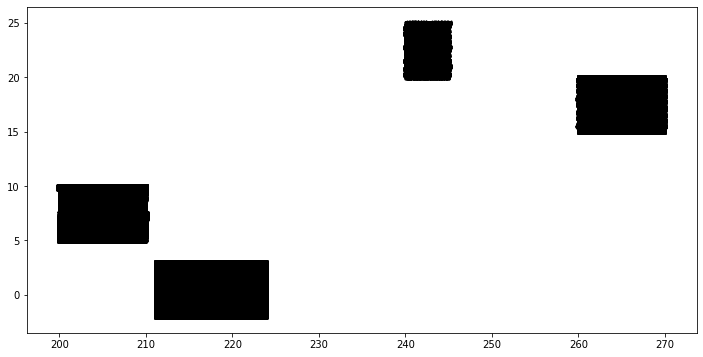

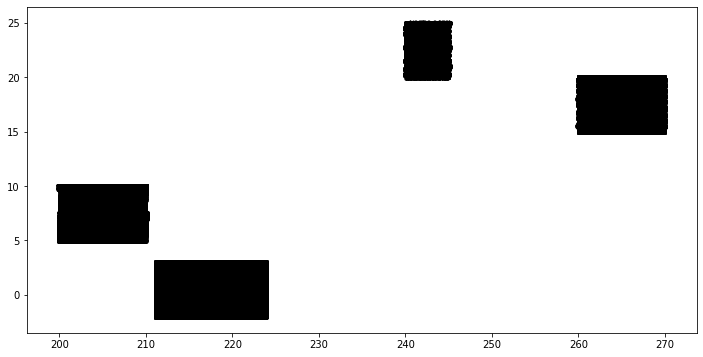

In [5]:
for cat in [catf, catg]:
    
    mask = cat['RMAG'] < 21
    
    plt.figure(figsize=(12, 6))
    plt.scatter(cat['RA'][mask][::20], cat['DEC'][mask][::20], s=1, c='k')
    plt.show()

### outline

Comparing BGS galaxies in dr9f with dr9g around Medium bright Stars (MS) but excluding overlap with Bright stars (i.e. stars with 13 < G < 16 only) where dr9f uses "fit_back" but dr9g does not.

Ratio dr9f/dr9g for: 1) BGS within MS masking radius, and 2) outside the MS masking radius.
* south: dr9f/dr9g=xxx dr9f/dr9g=xxx
* north: dr9f/dr9g=xxx dr9f/dr9g=xxx

Agreement / disagrement in dr9f / disagrement in dr9g for 1) within MS masking and 2) outside MS masking
* south: agree. / dissagr.f  / dissagr.g agree. / dissagr.f  / dissagr.g
* north: agree. / dissagr.f  / dissagr.g agree. / dissagr.f  / dissagr.g

If dissagree why?
* % not in LS
* % with rmag > 20
* % rejected by a BGS cut

r-magnitude comparison plots. Left: within MS masking radius. Right: outside MS masking radius.
* plots r-dr9g vs r-dr9f - r-dr9g

I've made galleries with:
* Agreements
* BGS In dr9f not in dr9g
* BGS In dr9g not in dr9f
Color key is:
green: bgs in both
red: bgs in dr9f only
blue: bgs in dr9g only



In [5]:
if survey == 'north': area = 110
elif survey == 'south': area = 182
print(area)

182


In [29]:
cats = {'dr9f':catf, 'dr9g':catg}

for catname, cat in zip(cats.keys(), cats.values()):
    
    bgs = ((cat['BGSBITS'] & 2**(20)) != 0) #BGS objects
    MS = ((cat['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BS = ((cat['MASKBITS'] & 2**1)!=0) #within BS masking radius
    inMS = (bgs) & (MS) & (~BS)
    outMS = (bgs) & (~MS) & (~BS)
    PSF = cat['TYPE'] == 'PSF'
    
    print('%s-%s: \t %.2f(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS)/area, np.sum(outMS)/area))
    print('\t PSF:%s-%s: \t %.2f/(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS & PSF)/area, np.sum(outMS & PSF)/area))
    print('\t NO-PSF:%s-%s: \t %.2f/(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS & ~PSF)/area, np.sum(outMS & ~PSF)/area))
    

south-dr9f: 	 26.54(inMS) 	 1478.25(outMS)
	 PSF:south-dr9f: 	 0.17/(inMS) 	 5.03(outMS)
	 NO-PSF:south-dr9f: 	 26.37/(inMS) 	 1473.23(outMS)
south-dr9g: 	 30.41(inMS) 	 1514.25(outMS)
	 PSF:south-dr9g: 	 0.16/(inMS) 	 5.15(outMS)
	 NO-PSF:south-dr9g: 	 30.25/(inMS) 	 1509.10(outMS)


In [7]:
22.65/28.65

0.7905759162303665

In [8]:
1464.69/1506.75

0.9720856147336984

In [9]:
#
if False:
    idx2, idx1, d2d, d_ra, d_dec = match_coord(catf['RA'], catf['DEC'], catg['RA'], catg['DEC'], search_radius=0.5)
    
    #
    MSf = ((catf['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BSf = ((catf['MASKBITS'] & 2**1)!=0) #within BS masking radius
    MSg = ((catg['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BSg = ((catg['MASKBITS'] & 2**1)!=0) #within BS masking radius

    inMSf = (MSf) & (~BSf)
    inMSg = (MSg) & (~BSg)
    outMSf = (~MSf) & (~BSf)
    outMSg = (~MSg) & (~BSg)

In [10]:
#
def run(cat1, cat2, idx1, idx2):
    
    tabmatch = Table()

    for key in cat1.dtype.names:
    
        tabmatch[key+'_f'] = cat1[key][idx1]
        tabmatch[key+'_g'] = cat2[key][idx2]
        
    tabmatch['dr9f'] = np.ones_like(cat1['RA'][idx1], dtype=bool)
    tabmatch['dr9g'] = np.ones_like(cat2['RA'][idx2], dtype=bool)
    
    print('tabmatched DONE...')
    
    tabf = Table()
    
    match_1 = np.zeros_like(cat1['DEC'], dtype=bool)
    match_1[idx1] = True
    df0 = np.ones(np.sum(~match_1), dtype=bool)
    df1 = np.full(np.sum(~match_1), np.nan) #z from gama
    df2 = np.full(np.sum(~match_1), np.nan, dtype=str) #z from gama
    
    for key in cat1.dtype.names:
        
        if isinstance(cat1[key][0], (str)): df = df2.copy()
        else: df = df1.copy()
            
        tabf[key+'_f'] = cat1[key][~match_1]
        if key in ['RA', 'DEC']: tabf[key+'_g'] = cat1[key][~match_1]
        else: tabf[key+'_g'] = df
    
    tabf['dr9f'] = df0
    tabf['dr9g'] = ~df0
    
    print('tabf DONE...')
    
    tabg = Table()
    
    match_2 = np.zeros_like(cat2['DEC'], dtype=bool)
    match_2[idx2] = True
    df0 = np.ones(np.sum(~match_2), dtype=bool)
    df1 = np.full(np.sum(~match_2), np.nan) #z from gama
    df2 = np.full(np.sum(~match_2), np.nan, dtype=str) #z from gama
    
    for key in cat2.dtype.names:
        
        if isinstance(cat2[key][0], (str)): df = df2.copy()
        else: df = df1.copy()
            
        if key in ['RA', 'DEC']: tabg[key+'_f'] = cat2[key][~match_2]
        else: tabg[key+'_f'] = df
        tabg[key+'_g'] = cat2[key][~match_2]
        
    tabg['dr9f'] = ~df0
    tabg['dr9g'] = df0
    
    print('tabg DONE...')
    
    tab = vstack([tabmatch, tabf, tabg])
    
    

    match = (tab['dr9f']) & (tab['dr9g'])
    bgsf = ((np.uint64(tab['BGSBITS_f']) & np.uint64(2**(20))) != 0)
    bgsg = ((np.uint64(tab['BGSBITS_g']) & np.uint64(2**(20))) != 0)
    
    #get bgs matched in each catalogue:
    print('total matched: \t %i' %(np.sum(match)/area))
    
    print('\t & BGS_f: \t %.3f' %(np.sum((bgsf))/area))
    print('\t\t & BGS_f & (BGS_g): \t %.3f ' %(np.sum((match) & (bgsf) & (bgsg))/area))
    print('\t\t & BGS_f & (~BGS_g): \t %.3f ' %(np.sum((bgsf) & (~bgsg))/area))
    disag = np.sum((bgsf) & (~bgsg))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (~match))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] > 20))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] < 20))/disag))
    
    
    print('\t & BGS_g: \t %.3f' %(np.sum((bgsg))/area))
    print('\t\t & BGS_g & (BGS_f): \t %.3f ' %(np.sum((match) & (bgsg) & (bgsf))/area))
    print('\t\t & BGS_g & (~BGS_f): \t %.3f ' %(np.sum((bgsg) & (~bgsf))/area))
    disag = np.sum((bgsg) & (~bgsf))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (~match))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] > 20))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] < 20))/disag))
    
    return tab


In [11]:
#
def run2(tab=None, mask=None):
    
    if mask is None: mask = np.ones_like(tab, dtype=bool)
        
    match = (tab['dr9f']) & (tab['dr9g'])
    bgsf = ((np.uint64(tab['BGSBITS_f']) & np.uint64(2**(20))) != 0)
    bgsg = ((np.uint64(tab['BGSBITS_g']) & np.uint64(2**(20))) != 0)
    
    #get bgs matched in each catalogue:
    print('total matched: \t %i' %(np.sum((match) & (mask))/area))
    
    print('\t & BGS_f: \t %.3f' %(np.sum((bgsf) & (mask))/area))
    print('\t\t & BGS_f & (BGS_g): \t %.3f ' %(np.sum((match) & (bgsf) & (bgsg) & (mask))/area))
    print('\t\t & BGS_f & (~BGS_g): \t %.3f ' %(np.sum((bgsf) & (~bgsg) & (mask))/area))
    disag = np.sum((bgsf) & (~bgsg) & (mask))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (~match) & (mask))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] > 20) & (mask))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] < 20) & (mask))/disag))
    
    
    print('\t & BGS_g: \t %.3f' %(np.sum((bgsg) & (mask))/area))
    print('\t\t & BGS_g & (BGS_f): \t %.3f ' %(np.sum((match) & (bgsg) & (bgsf) & (mask))/area))
    print('\t\t & BGS_g & (~BGS_f): \t %.3f ' %(np.sum((bgsg) & (~bgsf) & (mask))/area))
    disag = np.sum((bgsg) & (~bgsf) & (mask))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (~match) & (mask))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] > 20) & (mask))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] < 20) & (mask))/disag))
 

In [12]:
if True:
    tab = np.load(pathdir+'/all.npy')
    #tab_in = np.load(pathdir+'/in.npy')
    #tab_out = np.load(pathdir+'/out.npy')

* All BGS in dr9g within MS
    * & outside BS
* All BGS in dr9f within MS
    * & outside BS
    
* matched & bgsg & ~bgsf & inMSf & inMSg
* matched & bgsg & ~bgsf & inMSf & inMSg & outBSg & outBSf
    
Apologies for the confussion, postages examples are centred in all BGS within the MS and does not exclude galaxies within the bright stars. However, the fraction of BGS

In [13]:
#
bgsg = ((np.uint64(tab['BGSBITS_g']) & np.uint64(2**(20))) != 0)
bgsf = ((np.uint64(tab['BGSBITS_f']) & np.uint64(2**(20))) != 0)
match = (tab['dr9f']) & (tab['dr9g'])
MSf = ((np.uint64(tab['MASKBITS_f']) & np.uint64(2**11))!=0) #within MS masking radius
BSf = ((np.uint64(tab['MASKBITS_f']) & np.uint64(2**1))!=0) #within BS masking radius
MSg = ((np.uint64(tab['MASKBITS_g']) & np.uint64(2**11))!=0) #within MS masking radius
BSg = ((np.uint64(tab['MASKBITS_g']) & np.uint64(2**1))!=0) #within BS masking radius


In [14]:
mask = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg))
mask2 = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg)
mask3 = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg)) & ((BSf) | (BSg))
print('bgs in dr9g but not bgs in dr9f')
print('within MS in both \t within MS both & outside BS both \t within MS both & within BS both')
print(np.sum(mask), np.sum(mask2), np.sum(mask3))
print(np.sum(mask)/area, np.sum(mask2)/area, np.sum(mask3)/area)


bgs in dr9g but not bgs in dr9f
within MS in both 	 within MS both & outside BS both 	 within MS both & within BS both
7879 1107 6772
43.29120879120879 6.082417582417582 37.20879120879121


In [15]:
mask = (~bgsg) & (bgsf) & ((MSf) | (MSg))
mask2 = (~bgsg) & (bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg)
mask3 = (~bgsg) & (bgsf) & ((MSf) | (MSg)) & ((BSf) | (BSg))
print('bgs in dr9f but not bgs in dr9g')
print('within MS in both \t within MS both & outside BS both \t within MS both & within BS both')
print(np.sum(mask), np.sum(mask2), np.sum(mask3))
print(np.sum(mask)/area, np.sum(mask2)/area, np.sum(mask3)/area)


bgs in dr9f but not bgs in dr9g
within MS in both 	 within MS both & outside BS both 	 within MS both & within BS both
590 590 0
3.241758241758242 3.241758241758242 0.0


In [16]:
#inside MS
run2(tab=tab, mask=(((MSf) | (MSg)) & (~BSf) & (~BSg)))

total matched: 	 2563
	 & BGS_f: 	 26.544
		 & BGS_f & (BGS_g): 	 23.302 
		 & BGS_f & (~BGS_g): 	 3.242 
			 & not in LS: 	 6.102 %
			 & rmag > 20: 	 79.492 %
			 & rmag < 20: 	 14.407 %
	 & BGS_g: 	 29.434
		 & BGS_g & (BGS_f): 	 23.302 
		 & BGS_g & (~BGS_f): 	 6.132 
			 & not in LS: 	 0.806 %
			 & rmag > 20: 	 90.412 %
			 & rmag < 20: 	 8.781 %


In [17]:
#outside MS
run2(tab=tab, mask=(~((MSf) | (MSg)) & (~BSf) & (~BSg)))

total matched: 	 105070
	 & BGS_f: 	 1478.247
		 & BGS_f & (BGS_g): 	 1476.896 
		 & BGS_f & (~BGS_g): 	 1.352 
			 & not in LS: 	 77.642 %
			 & rmag > 20: 	 16.260 %
			 & rmag < 20: 	 6.098 %
	 & BGS_g: 	 1478.016
		 & BGS_g & (BGS_f): 	 1476.896 
		 & BGS_g & (~BGS_f): 	 1.121 
			 & not in LS: 	 88.725 %
			 & rmag > 20: 	 8.824 %
			 & rmag < 20: 	 2.451 %


### Comparison with GAMA

In [132]:
#comparison with GAMA

def get_isgama(ra, dec):
    
    keep = np.zeros_like(ra, dtype='?')

   # keep |= ((ra > 174.) & (ra < 186.) & (dec > -3.) & (dec < 2.)) #G12
    keep |= ((ra > 211.5) & (ra < 223.5) & (dec > -2.) & (dec < 3.)) #G15
    #keep |= ((ra > 129.) & (ra < 141.) & (dec > -2.) & (dec < 3.)) #G09
    
    return keep

gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

gama = gama[get_isgama(gama['RA'], gama['DEC'])]
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

gama = gama[gama['Z'] > 0.002] #Include only galaxies in GAMA

fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.11 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.89 %


In [137]:
#
tabingama = get_isgama(tab['RA_g'], tab['DEC_g'])
mask = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg) & (tabingama)

In [138]:
# matching LS8 with gama galaxies
idx2, idx1, d2d, d_ra, d_dec = match_coord(tab['RA_g'][mask], tab['DEC_g'][mask], gama['RA'], gama['DEC'], search_radius=0.5)

Doubly matched objects = 0
Final matched objects = 59


In [139]:
print('bgs dr9g not bgs dr9f inside MS outside BS and in G15 (matched with GAMA / all): \t %i / %i = %.2f' %(len(idx2), np.sum(mask), len(idx2)/np.sum(mask)))

bgs dr9g not bgs dr9f inside MS outside BS and in G15 (matched with GAMA / all): 	 59 / 185 = 0.32


### Comparing morphologies with Heatmaps

In [18]:
#
morphs_g = {}
morphs_f = {}
mask = (match)

for i in ['REX', 'EXP', 'DEV', 'SER', 'PSF']:
    
    morphs_g[i] = (mask) & (tab['TYPE_g'] == i)
    morphs_f[i] = (mask) & (tab['TYPE_f'] == i)


In [19]:
import seaborn as sns
def heatmap(data1, data2, vmin=None, vmax=None, file=None, ticks=None, fmt=".1f", mask=None, Area=None, log=False):
    
    import pandas as pd
    from matplotlib.colors import LogNorm
    N = len(data1.keys())
    keylist = list(data1.keys())
    matrix = [[0 for x in range(N)] for y in range(N)]
    if mask is None: mask = np.ones_like(data1[keylist[0]], dtype=bool)
    
    from itertools import product
    for i,j in product(range(N), range(N)):
        
        matrix[i][j] = np.sum((data1[keylist[i]]) & (data2[keylist[j]]) & (mask))/Area
        #print(keylist[i], keylist[j], matrix[i][j]) #sanity check
        
    keylist_g = [i+'_g' for i in keylist]
    keylist_f = [i+'_f' for i in keylist]
    df = pd.DataFrame(np.array(matrix), columns=keylist_f, index=keylist_g)
    #df = pd.DataFrame(np.tril(np.array(matrix)), columns=keylist, index=keylist)
    #df.replace(0, np.nan, inplace=True)
    
    if ticks is None: ticks = np.linspace(vmin, vmax, 5)
    
    fig = plt.figure(figsize=(12,10))
    log_norm = LogNorm(vmin=df.min().min(), vmax=df.max().max())
    if log: norm = log_norm
    else: norm = None
    ax = sns.heatmap(df, annot=True, annot_kws={"size": 14}, fmt=fmt, linewidths=.5, cmap='Reds',
                   norm=norm,
                    vmin = vmin, vmax=vmax,
                        cbar_kws={"ticks":ticks, 'label': r'objects/deg$^2$'})
    ax.figure.axes[-1].yaxis.label.set_size(22)
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        

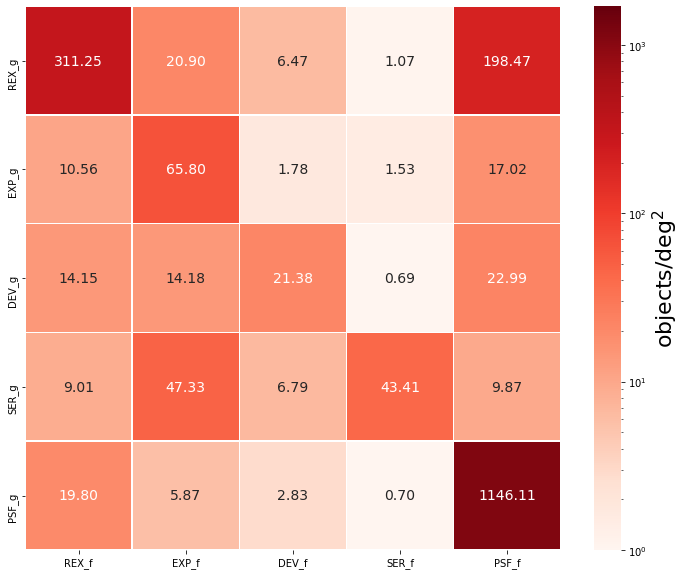

In [18]:
heatmap(morphs_g, morphs_f, vmin=1, vmax=1700, file=pathdir+'all_inside_morphs_heatmap', ticks=[1, 10, 100, 1000], 
        fmt=".2f", Area=area, log=True, mask = (((MSf) | (MSg)) & (~BSf) & (~BSg)))

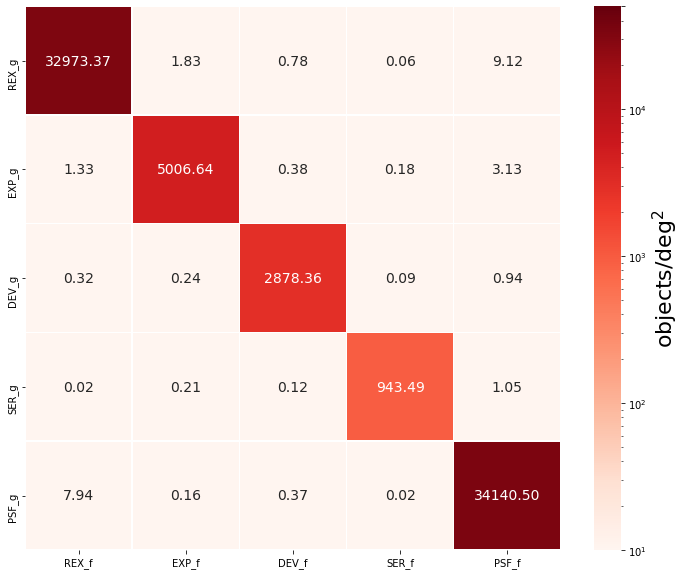

In [19]:
heatmap(morphs_g, morphs_f, vmin=10, vmax=50000, file=pathdir+'all_outside_morphs_heatmap', ticks=[1, 10, 100, 1000, 10000, 50000], 
        fmt=".2f", Area=area, log=True, mask = (~((MSf) | (MSg)) & (~BSf) & (~BSg)))

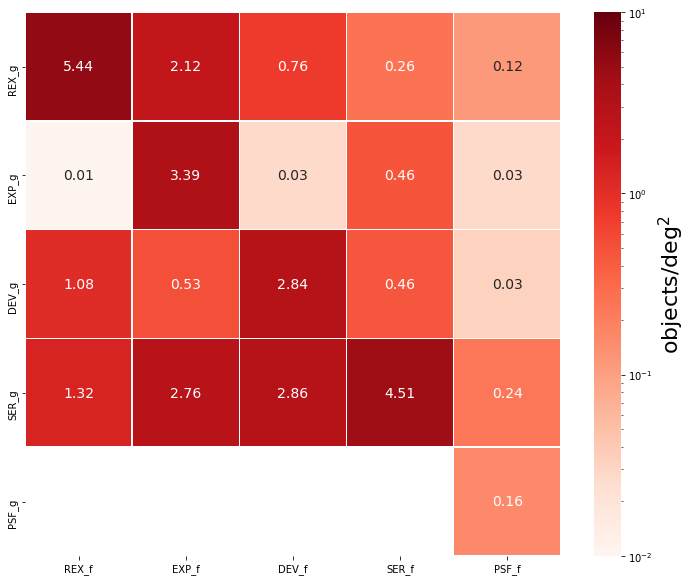

In [28]:
heatmap(morphs_g, morphs_f, vmin=0.01, vmax=10, file=pathdir+'bgs_inside_morphs_heatmap', ticks=[0.01, 0.1, 1, 10], 
        fmt=".2f", Area=area, log=True, mask = (((MSf) | (MSg)) & (~BSf) & (~BSg) & (bgsg) & (match)))

In [20]:
#
if False:
    np.save(pathdir+'/all', tab)
    np.save(pathdir+'/in', tab_in)
    np.save(pathdir+'/out', tab_out)

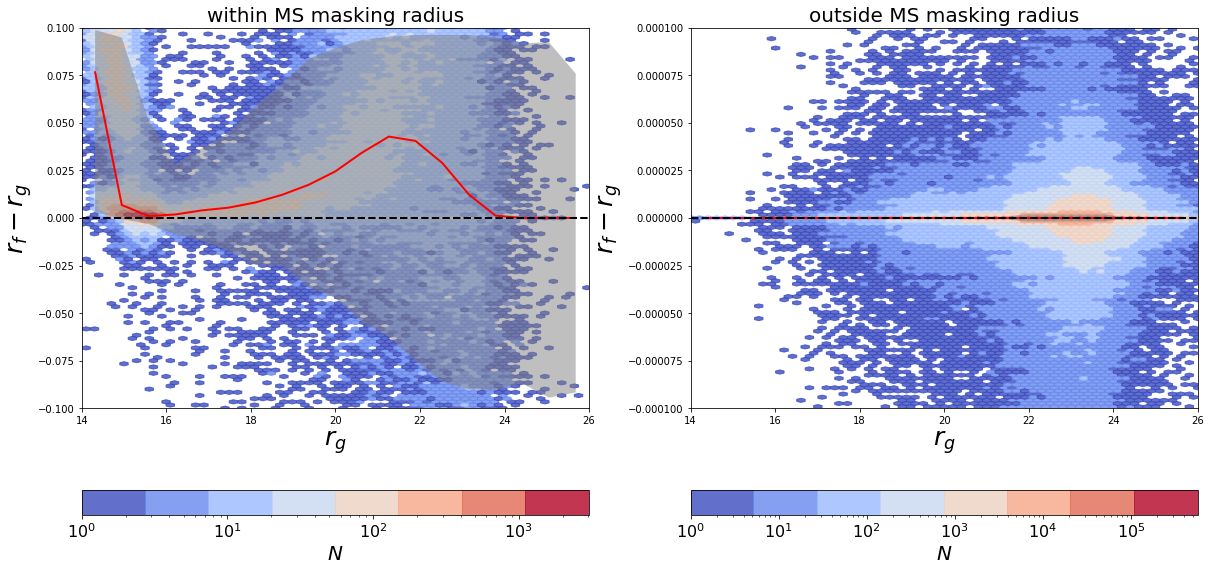

In [21]:
#(match) & (bgsg) & (~bgsf) & (MSf) & (MSg) & (~BSf) & (~BSg)
coord_in = {'$r_{g}$':tab['RMAG_g'], '$r_{f} - r_{g}$':(tab['RMAG_f'] - tab['RMAG_g'])}
coord_out = {'$r_{g}$':tab['RMAG_g'], '$r_{f} - r_{g}$':(tab['RMAG_f'] - tab['RMAG_g'])}
mask_in = ((MSf) | (MSg)) & (~BSf) & (~BSg)
mask_out = (~((MSf) | (MSg))) & (~BSf) & (~BSg)

fig    = plt.figure(figsize=(10*2.,10*1.))
gs     = gridspec.GridSpec(1, 2, hspace=0.15, wspace=0.20)
cmap = plt.get_cmap('coolwarm', 8)

ax = hexbin(coord=coord_in, catmask=((match) & (mask_in)), n=0, bins='log', title='within MS masking radius', cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                   file=None, fracs=False, area=None, cbar='horizontal', xlim=[14, 26], ylim=[-.1, .1], showmedian=True)
        
ax.axhline(0, lw=2, ls='--', c='k')


ax = hexbin(coord=coord_out, catmask=((match) & (mask_out)), n=1, bins='log', title='outside MS masking radius', cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                   file=None, fracs=False, area=None, cbar='horizontal', xlim=[14, 26], ylim=[-.0001, .0001], showmedian=True)
        
ax.axhline(0, lw=2, ls='--', c='k')



## Gallery

In [22]:
#
tabgall = Table()

indr9g = np.where(tab['dr9g'])
indr9f = np.where((tab['dr9f']) & (~tab['dr9g']))

for key in ['RA', 'DEC', 'RMAG', 'GMAG', 'ZMAG', 'REF_CAT', 'TYPE']:
    
    if isinstance(tab[key+'_g'][0], (str)): col = np.full(len(tab['dr9g']), np.nan, dtype=str)
    else: col = np.full(len(tab['dr9g']), np.nan)
    
    col[indr9g] = tab[key+'_g'][indr9g]
    col[indr9f] = tab[key+'_f'][indr9f]
    
    tabgall[key] = col
    

In [23]:
#
from postages_images import html_postages

coord = [tabgall['RA'], tabgall['DEC']]
veto = {'in both':((tab['dr9g']) & (tab['dr9f'])),
        'dr9f only':((~tab['dr9g']) & (tab['dr9f'])),
        'dr9g only':((tab['dr9g']) & (~tab['dr9f']))
       }

layer = 'dr9g'+'-'+survey
    
select = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg) & (tab['RMAG_g'] < 19.5)
#select = (tab['dr9g']) & (~tab['dr9f']) & (bgsg) & (MSg) & (~BSg)
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

#info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}

html_postages(cat=tab, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/bgs_dr9g_not_dr9f_r<19.5', htmltitle='bgs_dr9g_not_dr9f_r<19.5', 
              veto=veto, grid=[20,5], m=4, radius=4/3600, comparison=True)


sample size: 169


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9f_dr9g-north_svfields_fg_0.1.0_comparison/bgs_dr9g_not_dr9f_r<19.5.html
32.0 122


In [25]:
#
from postages_images import html_postages

coord = [tabgall['RA'], tabgall['DEC']]
veto = {'in both':((tab['dr9g']) & (tab['dr9f'])),
        'dr9f only':((~tab['dr9g']) & (tab['dr9f'])),
        'dr9g only':((tab['dr9g']) & (~tab['dr9f']))
       }

layer = 'dr9g'+'-'+survey
    
select = (match) & (~bgsg) & (bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg) & (tab['RMAG_f'] < 19.5)
#select = (tab['dr9g']) & (~tab['dr9f']) & (bgsg) & (MSg) & (~BSg)
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

#info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}

html_postages(cat=tab, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/bgs_dr9f_not_dr9g_r<19.5', htmltitle='bgs_dr9f_not_dr9g_r<19.5', 
              veto=veto, grid=[12,5], m=4, radius=4/3600, comparison=True)


sample size: 64


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9f_dr9g-north_svfields_fg_0.1.0_comparison/bgs_dr9f_not_dr9g_r<19.5.html
32.0 122


# DEV ZONE...

In [84]:
#
from postages_images import html_postages

coord = [tabgall['RA'], tabgall['DEC']]
veto = {'in both':((tab['dr9g']) & (tab['dr9f'])),
        'dr9f only':((~tab['dr9g']) & (tab['dr9f'])),
        'dr9g only':((tab['dr9g']) & (~tab['dr9f']))
       }

layer = 'dr9g'+'-'+survey
    
select = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg) & (tab['RMAG_g'] < 19.5)
#select = (tab['dr9g']) & (~tab['dr9f']) & (bgsg) & (MSg) & (~BSg)
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

#info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}

html_postages(cat=tab, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/bgs_dr9g_not_dr9f_r<19', htmltitle='bgs_dr9g_not_dr9f_r<19', 
              veto=veto, grid=[1,4], m=4, radius=4/3600, comparison=True)


sample size: 275


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9f_dr9g-south_svfields_fg_0.1.0_comparison/bgs_dr9g_not_dr9f_r<19.html
32.0 122
